<a href="https://colab.research.google.com/github/yashveersinghsohi/Shopify_Data_Science_Internship_Challenge/blob/main/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

****

# Dataset

Reading the dataset.

In [2]:
data = pd.read_csv("/content/Data.csv")
print(f"Shape of the dataset - {data.shape}")
print("First few rows in the dataset - ")
data.head()

Shape of the dataset - (5000, 7)
First few rows in the dataset - 


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


Looking at the data types and possible null values in the dataset.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


Clearly the data has no null values.

****

# How was the AOV calculated in the first place?

It seems that the `Average Order Value` was calculated by taking the mean of the `order_amount` column as shown below.

In [4]:
print("AOV calculated in the question: {}$".format(round(data["order_amount"].mean(), 2)))

AOV calculated in the question: 3145.13$


****

# What is wrong in the AOV calculation above?

Since we have a much higher average than what we intuitively expect, it makes sense to plot the distribution of `order_amount` and check if we have any outliers or not.

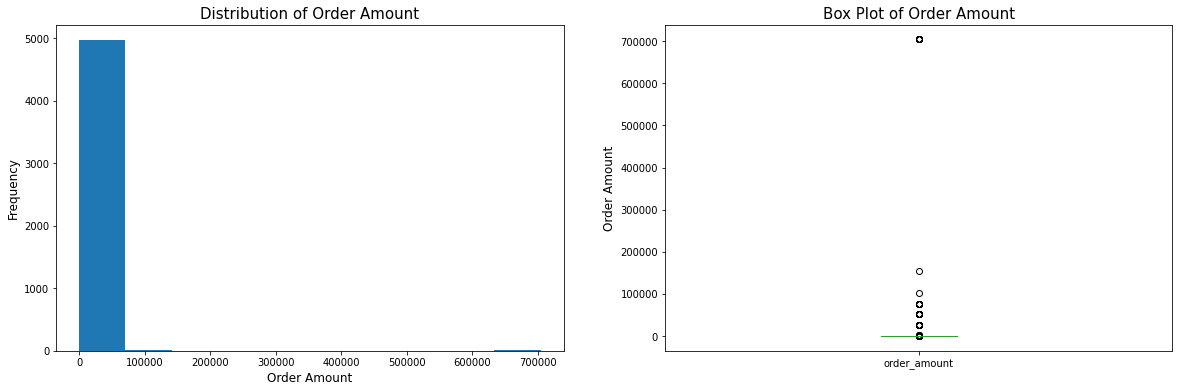

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
data["order_amount"].plot.hist(ax=ax[0])
ax[0].set_xlabel("Order Amount", size=12)
ax[0].set_ylabel("Frequency", size=12)
ax[0].set_title("Distribution of Order Amount", size=15)

data["order_amount"].plot.box(ax=ax[1])
ax[1].set_ylabel("Order Amount", size=12)
ax[1].set_title("Box Plot of Order Amount", size=15)
plt.show()

The distribution clearly reveals that there are a hige outliers in `order_amounts`.

In order to identify these outliers, lets take a closer look on how the `order_amounts` are calculated:

$$order\_amount_i = total\_items_i*amount\_per\_item_i$$

This means that the amount a customer pays for an order $i$ is the product of the number of items purchased and the amount of one such item. In this case the item is a pair of Sneakers.

**Thus, to identify outliers in `order_amount`, it would make sense to identify outliers in `total_items` and in `amount_per_item`.**

Note: The column for `amount_per_item` needs to be created (it was not given in the input dataset).

****

# Identifying Outliers in `amount_per_item`, and `total_items`

Creating `amount_per_item`

In [6]:
data["amount_per_item"] = data["order_amount"]/data["total_items"]

**Distribution of `amount_per_item`**

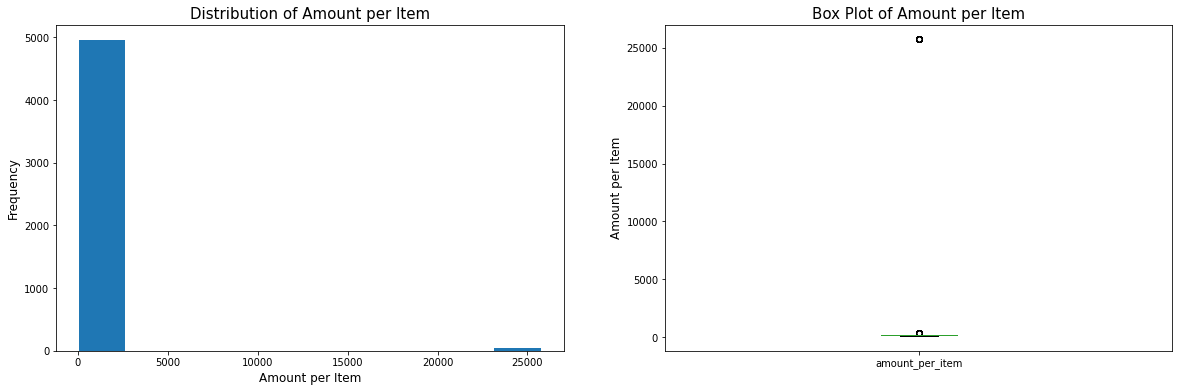

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
data["amount_per_item"].plot.hist(ax=ax[0])
ax[0].set_xlabel("Amount per Item", size=12)
ax[0].set_ylabel("Frequency", size=12)
ax[0].set_title("Distribution of Amount per Item", size=15)

data["amount_per_item"].plot.box(ax=ax[1])
ax[1].set_ylabel("Amount per Item", size=12)
ax[1].set_title("Box Plot of Amount per Item", size=15)
plt.show()

As suspected, there are a few very large outliers. It does not seem likely that a pair of Sneakers would cost close to 2500$. Even if that was true, it certainly does not makes sense to include this in the AOV calculation.

Lets see how many outlier values lie in the top $1$ percentile of the distribution above.

In [8]:
condition = data["amount_per_item"]>data["amount_per_item"].quantile(0.99)
amount_per_item_outliers = data[condition]
print(f"Number of Outliers in distribution of Amount per Item - {amount_per_item_outliers.shape[0]}")
print("Outlier 'Amount per Item' values - {} $".format(*amount_per_item_outliers["amount_per_item"].unique()))
print("Shop id(s) corresponding to shops that sell these expensive sneakers - {}".format(*amount_per_item_outliers["shop_id"].unique()))

Number of Outliers in distribution of Amount per Item - 46
Outlier 'Amount per Item' values - 25725.0 $
Shop id(s) corresponding to shops that sell these expensive sneakers - 78


This reveals that there are `46` outliers in `amount_per_item` column, where each pair of sneakers were sold for `25,725$`. This seems like a exorbitant amount for a pair. It could either be a mistake, or the sneakers were celebrity editions. Either way, these should not be included in the AOV calculation, as they skew the average heavily.

**Distribution of `total_items`**

Table showing total number of items sold on each order, and their value counts
    total_items  count
0            1   1830
1            2   1832
2            3    941
3            4    293
4            5     77
5            6      9
6            8      1
7         2000     17



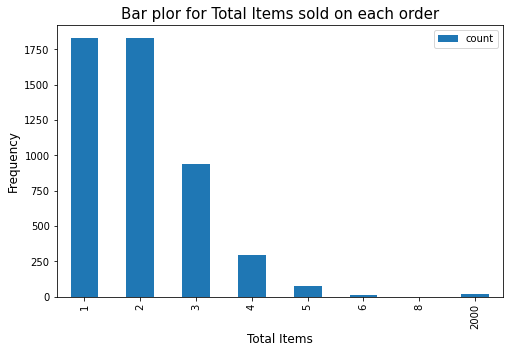

In [9]:
temp = pd.DataFrame(
    np.c_[
          data["total_items"].value_counts().sort_index().index,
          data["total_items"].value_counts().sort_index().to_numpy()
        ],
    columns=["total_items", "count"]
  )
print("Table showing total number of items sold on each order, and their value counts\n", temp, end="\n\n")

fig, ax = plt.subplots(figsize=(8, 5))
temp.set_index("total_items").plot.bar(ax=ax)
ax.set_xlabel("Total Items", size=12)
ax.set_ylabel("Frequency", size=12)
ax.set_title("Bar plor for Total Items sold on each order", size=15)
plt.show()

It seems there are 17 orders where customers bought $2000$ sneakers on each order. This definitely seems like an outlier, and we should remove these orders before calculating AOV to ensure that the value calculated is not heavily skewed.

****

# Removing Outliers and Calculating AOV again

Filtering Outliers

In [10]:
condition1 = data["amount_per_item"]<data["amount_per_item"].quantile(0.99)
condition2 = data["total_items"]!=2000
data = data[condition1 & condition2]
print(f"Shape of dataset after outlier removal - {data.shape}")
print("First few rows of the new dataset - ")
data.head()

Shape of dataset after outlier removal - (4903, 8)
First few rows of the new dataset - 


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,amount_per_item
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 4:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,156.0


Corrected AOV

In [11]:
print("Corrected Average Order Value - {}$".format(round(data["order_amount"].mean(), 2)))

Corrected Average Order Value - 300.16$


Average Total Items purchased on each order

In [12]:
print("Average Total Items purchased on each order - {}".format(round(data["total_items"].mean())))

Average Total Items purchased on each order - 2


Average price of each pair of sneakers

In [13]:
print("Average price of each pair of sneakers - {}$".format(data["order_amount"].sum()/data["total_items"].sum()))

Average price of each pair of sneakers - 150.4$


These values make much more sense intuitively. Collectively they indicate that on average customers bought 2 pairs of sneakers, which on average costed close to 150\$. Hence on each order these customers spent about 300\$.

****

# What New Metric can be used for this dataset?

I feel it is more appropriate to analyse the data with more than one metric. To do this, I am keep track of the following 4 quantities for each store in the dataset:
1. **`footfall`**: The number of users that order from each store.
2. **`cart_size`**: The average number of items in a single order from each store.
3. **`item_cost`**: The average cost of each item in the store.
4. **`revenue`**: The total revenue generated by each store.

Out of these, `revenue` is what most companies would be interested in, as that is what drives the business. The other three metrics are used to understand what drives the `revenue` generated from each store, and they provide hints as to what can be done to improve the `revenue` of a particular store.

In [14]:
grp_by_store = data.groupby(by=["shop_id"])
footfall = grp_by_store["user_id"].count()
cart_size = grp_by_store["total_items"].mean()
item_cost = grp_by_store["amount_per_item"].mean()
revenue = grp_by_store["order_amount"].sum()

Note: The `footfall` is not measured using distinct users. This is because the fact that there could be many orders placed by a single user suggests that the given store is popular, and I would like to capture that information.

In [15]:
metrics = pd.DataFrame(
    np.c_[footfall, cart_size, item_cost, revenue],
    columns = ["footfall", "cart_size", "item_cost", "revenue"]
)
metrics.index.name = "shop_id"

****

# Inferences made from these Metrics

Let us look at the minimum and maximum `revenues` generated by any store, and what are the values for the other metrics in these cases.

**Maximum revenue store**

In [16]:
metrics[metrics["revenue"] == metrics["revenue"].max()]

,footfall,cart_size,item_cost,revenue
shop_id,,,,
86,61.0,1.934426,196.0,23128.0


**Miminum revenue store**

In [17]:
metrics[metrics["revenue"] == metrics["revenue"].min()]

,footfall,cart_size,item_cost,revenue
shop_id,,,,
89,42.0,1.809524,90.0,6840.0


These numbers clearly indicate that the store generating the highest revenue had on average more expensive sneakers, and more number of items being bought per order. Additionally, the store also had greater number of visitors.

The plots below show how the metrics `footfall`, `cart_size`, and `item_cost` influence `revenue` of a store, and what sort of inferences we can draw from them.

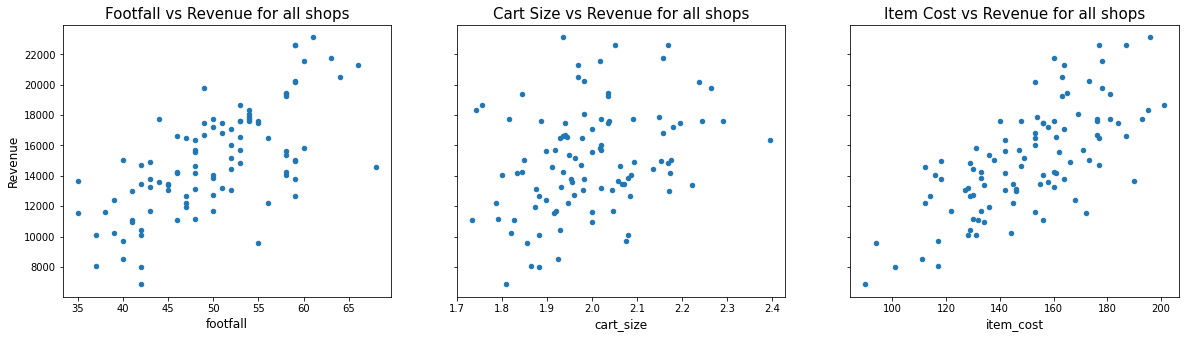

In [18]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
metrics[["footfall", "revenue"]].plot.scatter(ax=ax[0], x="footfall", y="revenue")
metrics[["cart_size", "revenue"]].plot.scatter(ax=ax[1], x="cart_size", y="revenue")
metrics[["item_cost", "revenue"]].plot.scatter(ax=ax[2], x="item_cost", y="revenue")

ax[0].set_xlabel("footfall", size=12)
ax[0].set_ylabel("Revenue", size=12)
ax[0].set_title("Footfall vs Revenue for all shops", size=15)

ax[1].set_xlabel("cart_size", size=12)
ax[1].set_title("Cart Size vs Revenue for all shops", size=15)

ax[2].set_xlabel("item_cost", size=12)
ax[2].set_title("Item Cost vs Revenue for all shops", size=15)

plt.show()

The left-most graph indicates that the revenue of each store generally increases with the number of customers visiting the store. However, there are quite a few cases where stores with lower footfall outperformed stores with higher footfall. This could be because some stores sell expensive sneakers, and hence need lower number of customers to generate same or greater revenue. There could be many other reasons that should ideally be analysed using datasets about the stores itself.

The middle graph indicates that similar to footfall, the revenue also generally increases with the average number of items in each order at a store. However, there are more deviations here. This makes sense, as stores with expensive sneakers can easy outperform other stores by even selling less pairs of sneakers in each order.

Lastly, the right most graph is similar in its story that if the average price of a sneaker being sold at a store is high, the revenue generated will also be high. There are deviations in this case as well, and we should use the data of individual stores to judge what they are doing right and what they are doing wrong, which will enable us to propose steps for the business to improve revenue across all underperformers.

****